# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Processing of Dataset 1

In [2]:
cyber1 = pd.read_csv('/kaggle/input/cyberbully-detection-dataset/cb_multi_labeled_balanced.csv')
cyber1

,text,label
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying
2,"the only thing i wish, i wish a nigga would",ethnicity/race
3,You saudias are not friends of Muslim idiots c...,religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion
...,...,...
99985,Thank fuck they didn’t dance remix Peru #LoveI...,not_cyberbullying
99986,Sierra Canyon vs. Alemany - California High Sc...,not_cyberbullying
99987,@queenbellaxoxo @PontiacMadeDDG @HalleBailey B...,gender/sexual
99988,What you like yo nigga to call you,ethnicity/race


In [3]:
cyber1['label'].value_counts()

not_cyberbullying    50000
ethnicity/race       17000
gender/sexual        17000
religion             15990
Name: label, dtype: int64

In [4]:
cyber1.drop_duplicates(subset = ['text'], inplace = True)
cyber1.duplicated().sum()

0

# Data Processing of Dataset 2

In [5]:
cyber2 = pd.read_csv('/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv')
cyber2.rename(columns = {'tweet_text' : 'text', 'cyberbullying_type' : 'label'}, inplace = True)
cyber2

,text,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [6]:
cyber2['label'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: label, dtype: int64

In [7]:
cyber2.drop_duplicates(subset = ['text'], inplace = True)
cyber2.duplicated().sum()

0

# Splitting Data

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming cyber1 is your DataFrame with columns 'text' and 'label'
texts = cyber1['text']
labels = cyber1['label']

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
label_mapping = {original_label: int_label for original_label, int_label in zip(cyber1['label'], encoded_labels)}
print(label_mapping)
# Split the data into training and testing sets (80-20 split)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets (80-20 split)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

{'ethnicity/race': 0, 'not_cyberbullying': 2, 'religion': 3, 'gender/sexual': 1}


# Importing and Fine Tuning the Model

In [10]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader
import torch
import numpy as np

# Define a function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute classification report
    class_report = classification_report(labels, predictions, output_dict=True)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, predictions).tolist() # Convert to a list to make it JSON serializable

    # Combine all the metrics into a dictionary
    metrics = {'accuracy': accuracy, 'classification_report': class_report, 'confusion_matrix': conf_matrix}

    return metrics

# Load the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Prepare your data
def tokenize_data(data, labels):
    encodings = tokenizer(data, truncation=True, padding=True)
    return {"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask'], "labels": labels}

train_texts = list(train_texts)
valid_texts = list(valid_texts)
train_data = tokenize_data(train_texts, train_labels)
valid_data = tokenize_data(valid_texts, valid_labels)

# Create a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create train and validation datasets
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)

# Define the XLNet model for sequence classification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(set(labels)))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./output',  # Directory for storing outputs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',   # Directory for storing logs
    report_to=[]            # Disable all logging
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,  # or test_dataset
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Step,Training Loss
500,0.195700
1000,0.071000
1500,0.047200
2000,0.053400
2500,0.040100
3000,0.027100
3500,0.035800
4000,0.032100


TrainOutput(global_step=4000, training_loss=0.06279716110229493, metrics={'train_runtime': 4995.4214, 'train_samples_per_second': 12.81, 'train_steps_per_second': 0.801, 'total_flos': 1.531065490935744e+16, 'train_loss': 0.06279716110229493, 'epoch': 1.0})

# Testing the Model

In [11]:
test_texts = list(test_texts)
test_data = tokenize_data(test_texts, test_labels)
test_dataset = CustomDataset(test_data)
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.022765299305319786, 'eval_accuracy': 0.9956495649564957, 'eval_classification_report': {'0': {'precision': 0.9925595238095238, 'recall': 0.9973086124401914, 'f1-score': 0.994928400954654, 'support': 3344}, '1': {'precision': 0.9985132322331252, 'recall': 0.993491124260355, 'f1-score': 0.9959958475456029, 'support': 3380}, '2': {'precision': 0.9968401303446233, 'recall': 0.9971355195574871, 'f1-score': 0.9969878030714533, 'support': 10124}, '3': {'precision': 0.9920584498094028, 'recall': 0.9914285714285714, 'f1-score': 0.9917434106065417, 'support': 3150}, 'accuracy': 0.9956495649564957, 'macro avg': {'precision': 0.9949928340491687, 'recall': 0.9948409569216513, 'f1-score': 0.994913865544563, 'support': 19998}, 'weighted avg': {'precision': 0.9956539338471646, 'recall': 0.9956495649564957, 'f1-score': 0.995649704930618, 'support': 19998}}, 'eval_confusion_matrix': [[3335, 1, 4, 4], [18, 3358, 2, 2], [6, 4, 10095, 19], [1, 0, 26, 3123]], 'eval_runtim

# Visualizing the results

In [12]:
import plotly.figure_factory as ff
import numpy as np

# Your confusion matrix
confusion_matrix = np.array([[3333, 2, 4, 5], [17, 3362, 0, 1], [16, 7, 10074, 27], [3, 3, 26, 3118]])

# Your class labels
class_labels = ['Ethnicity/Race', 'Gender/Sexual', 'Not Cyberbullying', 'Religion']

# Create the heatmap using plotly
fig = ff.create_annotated_heatmap(confusion_matrix,
                                  x=class_labels,
                                  y=class_labels,
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    xaxis={'side': 'top'}
)

fig.show()

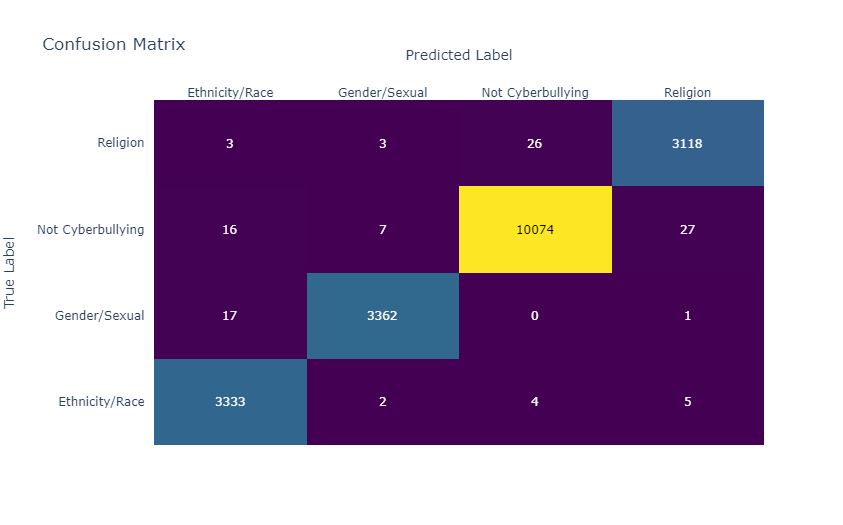

In [14]:
example_text = ['I can do this all day']
encodings = tokenizer(example_text, truncation=True, padding=True)
example_encodings = {"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask']} # Replace 0 with an appropriate label or dummy label
example_dataset = CustomDataset(example_encodings)
predictions = trainer.predict(example_dataset)
predicted_label_idx = np.argmax(predictions.predictions, axis=-1)[0]
label_mapping = {'ethnicity/race': 0, 'not_cyberbullying': 2, 'religion': 3, 'gender/sexual': 1}
predicted_label = [key for key, value in label_mapping.items() if value == predicted_label_idx]

print(f"Predicted label: {predicted_label}")

Predicted label: ['not_cyberbullying']
